### Import

In [2]:
import cv2
import torch
import IPython
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt
from typing import List, Dict, NoReturn

### Params

- STREAM_INPUT - Video streaming source
- KNOWN_DISTANCE - Known distance from the reference image *Inches
- PERSON_WIDTH - Person avg width in real life *Inches
- CAR_WIDTH - Car width in real life *Inches
- BLACK_RGB - RGB Value for black
- FIG_SIZE - Streaming figsize view

In [3]:
STREAM_INPUT = './resource/sample.mp4'
KNOWN_DISTANCE = 120.0
PERSON_WIDTH = 16.0
CAR_WIDTH = 100.0
INCH_TO_METER = 0.0254
BLACK_RGB = (0, 0, 0)
FIG_SIZE = (12,12)

### Model

- Currently used pretrined YoloV5

In [4]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /home/koren/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-1-31 torch 1.7.1+cu110 CUDA:0 (GeForce RTX 3080 Laptop GPU, 7982MiB)

Fusing layers... 
Model Summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


### Object detection

In [6]:
def predict(image: np.ndarray, calc_distance: bool = True) -> List[Dict]:
    detections =[]
    res = model(image).pandas().xyxy[0]
    for i, d in res.iterrows():
        x, y, w, h = int(d['xmin']) , int(d['ymin']) , int(d['xmax'] - d['xmin']), int(d['ymax']- d['ymin'])
        obj = {'cls': d['name'] , 'bbox': [x, y, w, h]}
        obj['distance'] = distance(obj) if calc_distance else ''
        detections.append(obj)        

    return detections

### Distance measurement

- focal_distance - ( reference_width * known distance from the object ) / real object width 
- distance_finder - ( focal_distance * real object width ) / object width in frame 


In [7]:
def focal_distance(measured_distance: float, real_width: float, width_in_rf: float) -> float:
    return (measured_distance * width_in_rf) / real_width


def distance_finder(focal_length : float, real_object_width: float, width_in_frmae: float) -> float:
    return (focal_length * real_object_width) / width_in_frmae


def distance(detect: Dict) -> str:
    return {'person': round(distance_finder(focal_person, PERSON_WIDTH, detect['bbox'][2]) * INCH_TO_METER, 1),
            'car': round(distance_finder(focal_car, CAR_WIDTH, detect['bbox'][2]) * INCH_TO_METER, 1)}.get(detect['cls'], '')

### Preview

- display - display video streaming live with detections

In [8]:
def display(frame: np.ndarray, detections: List[Dict]) -> NoReturn:
    for d in detections:
        cv2.rectangle(frame, d['bbox'], BLACK_RGB, 1)
        cv2.putText(frame, '{} {}'.format(d['distance'], d['cls']) , (d['bbox'][0], d['bbox'][1]- 20), cv2.FONT_HERSHEY_COMPLEX, .7, BLACK_RGB, 2)
    plt.figure(figsize=FIG_SIZE)
    plt.imshow(frame)
    f = BytesIO()
    plt.savefig(f, format='jpeg'), plt.close()
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    IPython.display.clear_output(wait=True)

### Reference objects

- Used to determine detected object size to the real world object
- Currently calculated for person & cars

In [9]:
ref_person = cv2.imread('./resource/ref_person.jpg')
ref_car = cv2.imread('./resource/ref_car.jpg')

person_data = predict(ref_person, False)
car_data = predict(ref_car, False)

focal_person = focal_distance(KNOWN_DISTANCE, PERSON_WIDTH, person_data[0]['bbox'][2])
focal_car = focal_distance(KNOWN_DISTANCE, CAR_WIDTH, car_data[0]['bbox'][2])

### Stream

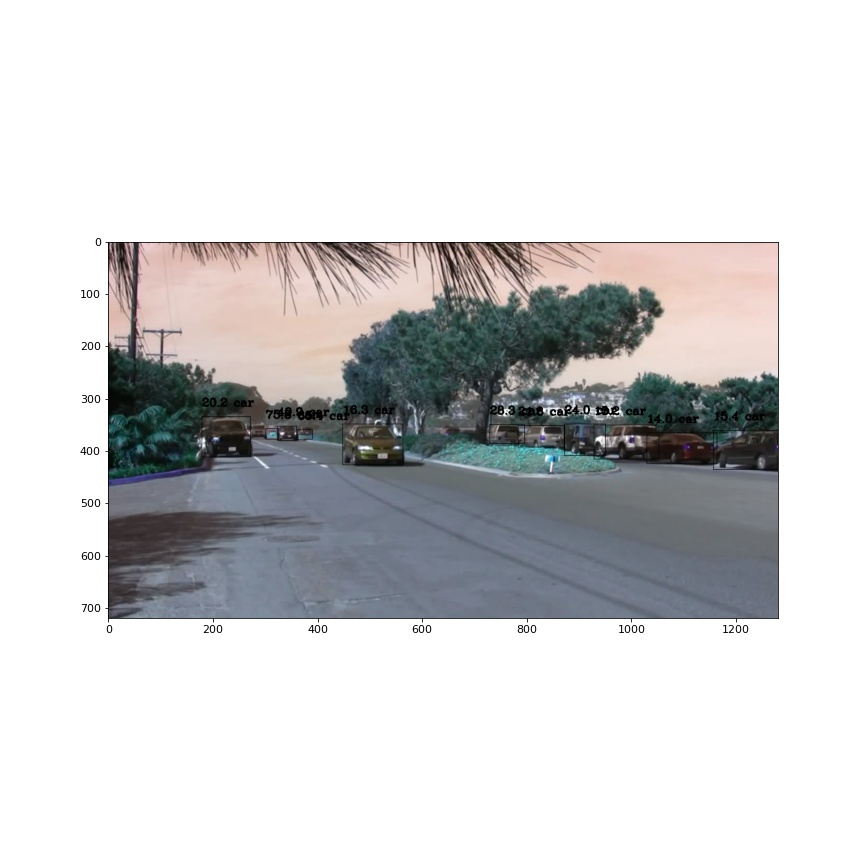

In [ ]:
cap = cv2.VideoCapture(STREAM_INPUT)
while cap.isOpened():
    ret, frame = cap.read()
    detections = predict(frame)
    display(frame, detections)